## Use the Hurst exponent to evaluate optimal pairs from a basket of assets
* assets in the basket are from sp500
* use to asses whether time series speed of diffusion from its initial value is slower than geo random walk
* speed of diffusion:
    * Var(tau) = <|z(t+tau)-z(t)|^2>
        * can be aprox <|z(t + τ) − z(t)|^2> ∼ tau^(2H)
        * H is Hurst expo
        * Geo random walk has H=0.5
        * As H decreases to 0, speed of diffusion reduces so price mean-reverting
        * As H increases to 1, price is increasingly trending
* use spread to calculate H, rank pairs by H value (low being optimal for mean reversion strat)
* as described in (A Machine Learning based Pairs Trading Investment Strategy (Simão Moraes Sarmento, Nuno Horta))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import yfinance as yf
import itertools
import math
from co import *
import ndtest

## Calculate the Hurst exponent of a time series


In [ ]:
def get_hurst_exponent(time_series, max_lag=20):
    lags = range(2, max_lag)
    
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]

## Asset list and dates or calibration and trading

In [ ]:
#Asset list
tickers = pd.read_csv('constituents_csv.csv', index_col=1)
asset_list=tickers['Symbol'].tolist()
lst=asset_list[0:50]

#dates for model calibration
start_data='2019-08-19'
end_data='2022-08-19'

#dates for trading with algo
start_trade='2022-01-01'
end_trade='2022-06-01'

index_comp='SPY'

#number of pairs traded
n=10

## Calculate Hurst exponent for the spread of every possible pair combo

In [ ]:
pair_order_list = itertools.combinations(lst,2)
pairs=list(pair_order_list)
pairs[0][1]
lst=[]
for i in range(0,len(pairs)):
    asset1=pairs[i][0]
    asset2=pairs[i][1]
    
    #adjusted close and spread of asset pairs
    X = yf.download(asset1, start = start_data, end=end_data)
    X.reset_index(inplace=True)
    np.log(X['Adj Close']) - np.log(X['Adj Close'].shift(1))
    date=X['Date']
    date=date.to_frame()

    X=X['Adj Close']
    X_df=X.to_frame()
    X_df=X_df.rename(columns={'Adj Close': asset1}).dropna()

    Y = yf.download(asset2, start = start_data, end=end_data)
    Y.reset_index(inplace=True)
    np.log(Y['Adj Close']) - np.log(Y['Adj Close'].shift(1))

    Y=Y['Adj Close']
    Y_df=Y.to_frame()
    Y_df=Y_df.rename(columns={'Adj Close': asset2}).dropna()

    pairs_df=X_df.join(Y_df).join(date).set_index('Date').dropna()

    #calculate spread of adjusted close price between asset pair
    pairs_df['spread'] = pairs_df[asset1] - pairs_df[asset2]
    
    hurst_exp = get_hurst_exponent(pairs_df['spread'].values, 500)
    lst.append(tuple((pairs[i],hurst_exp)))
    
lst.sort(key=lambda a: a[1])

In [33]:
res = list(zip(*lst))
pairs_lst=[]
asset1_lst=[]
asset2_lst=[]
h_expo=[]
possible_pairs=[]
for i in range(0,len(lst)): 
    asset1_lst.append(res[0][i][0])
    asset2_lst.append(res[0][i][1])
    h_expo.append(res[1][i])
    possible_pairs.append(asset1_lst[i]+'-'+asset2_lst[i])
hurst_df=pd.DataFrame(possible_pairs,h_expo)
hurst_df = pd.DataFrame(h_expo, index =possible_pairs,columns =['Hurst expo'])
print("Hurst exponent for all possible pairs:")

hurst_df


Hurst exponent for all possible pairs:


,Hurst expo
ADM-ABC,0.030749
AOS-ADI,0.052112
APD-AMZN,0.053331
ARE-GOOG,0.058664
ARE-GOOGL,0.058985
...,...
AFL-AMZN,0.472588
ALGN-ANTM,0.472766
AMZN-AIG,0.473629
AMZN-APA,0.481570


## Find optimal unique pairs with lowest Hurst exponent

In [ ]:
selected_stocks = []
selected_pairs = []
opt_asset1=[]
opt_asset2=[]
for i in range(0,len(asset1_lst)):
    s1=asset1_lst[i]
    s2=asset2_lst[i]
  
    if (s1 not in selected_stocks) and (s2 not in selected_stocks):
        selected_stocks.append(s1)
        selected_stocks.append(s2)
        pair=s1+' and '+s2
        selected_pairs.append(pair)
    
    if len(selected_pairs) == math.comb(len(lst),2):
        break
        

print('Optimal Pairs with lowest Hurst expo:',selected_pairs)
opt_asset1=selected_stocks[0:len(selected_stocks)-1:2]
opt_asset2=selected_stocks[1:len(selected_stocks):2]

    

## Fit copulas to each optimal pair using AIC and BIC and test if good fit with K-S test

In [ ]:
df=pd.DataFrame()
best_cop_lst=[]
for i in range(0,len(opt_asset1)):
    #assets (yfinance ticker)
    asset1=opt_asset1[i]
    asset2=opt_asset2[i]
    pairs=selected_pairs[i] #insert name of asset 1 and asset 2

    #fetch log returns of pair (to model calibration)

    X = yf.download(asset1, start = start_data, end=end_data)
    X.reset_index(inplace=True)
    X.tail()
    X['Log_Returns'] = np.log(X['Adj Close']) - np.log(X['Adj Close'].shift(1))
    x = X['Log_Returns'].drop(labels=0, axis=0).dropna()
    date=X['Date'].drop(labels=0,axis=0)
    date=date.to_frame()




    Y = yf.download(asset2, start = start_data, end=end_data)
    Y.reset_index(inplace=True)
    Y.tail()
    Y['Log_Returns'] = np.log(Y['Adj Close']) - np.log(Y['Adj Close'].shift(1))
    y = Y['Log_Returns'].drop(labels=0, axis=0).dropna()

    #fit distribution to element in pair + probability integral transform to get marginal uniform

    param1 = stats.t.fit(x)
    dist1=stats.t(*param1)
    u=dist1.cdf(x)
    param2=stats.t.fit(y)
    dist2=stats.t(*param2)
    v=dist2.cdf(y)



    #put returns in a data frame with corresponding dates
    x_df=x.to_frame()
    y_df=y.to_frame()

    a=y_df.rename(columns={'Log_Returns': asset2})
    b=x_df.rename(columns={'Log_Returns': asset1})

    p =a.join(b)
    x=p.join(date)

    returns_df=x.set_index('Date')


    #fit bivariate copula family to data 
    #calculate Akaike information criterion, Bayesion information criterion and KS value to help determine good fit

    pair=[pairs]
    copulas_df = pd.DataFrame(index=pair, columns=['copula', 'parameter', 'aic', 'bic', 'KS_pvalue'])


    best_aic = np.inf
    best_copula= None


    copulas=[GaussianCopula(),GumbelCopula(), ClaytonCopula(),FrankCopula()]
    for copula in copulas:
        copula.fit(u,v)

        L = copula.log_likelihood(u,v)
        aic = 2 * copula.num_params - 2 * L
        if aic < best_aic:
            best_aic = aic
            best_bic = copula.num_params * np.log(len(u)) - 2 * L
            best_copula = copula

            # calculate KS-pvalue
            smp = copula.sample(size=len(u)) # generate sample from fit copula
            s_u = smp[:,0]
            s_v = smp[:,1]
            ks_pval = ndtest.ks2d2s(u,v,s_u,s_v)

            if isinstance(copula, ArchimedeanCopula):
                best_param = copula.alpha
            else:
                best_param = copula.rho
    
    best_cop_lst.append(best_copula)
    copulas_df.loc[pair] = [best_copula.name, best_param, best_aic, best_bic, ks_pval]
    df=df.append(copulas_df)




In [15]:
df

,copula,parameter,aic,bic,KS_pvalue
ADM and ABC,Gaussian,0.425854,-451.892147,-447.264105,0.566356
AOS and ADI,Gaussian,0.505171,-502.235208,-497.607166,0.186951
APD and AMZN,Gaussian,0.379266,-420.098778,-415.470736,0.282734
ARE and GOOG,Gaussian,0.447343,-465.743336,-461.115295,0.222887
AAPL and AMAT,Gaussian,0.60703,-573.252947,-568.624906,0.207337
AON and ANET,Gaussian,0.407004,-439.371301,-434.74326,0.259305
AAP and ALB,Gaussian,0.354038,-401.771051,-397.14301,0.323573
ABT and AWK,Gaussian,0.512812,-507.073452,-502.445411,0.226867
MO and AEE,Gaussian,0.343429,-393.5404,-388.912359,0.260405
MMM and A,Gaussian,0.428641,-453.716618,-449.088576,0.514289


## Algo returns for specific trading period
*refer to (Pairs Trading with Copulas.ipynb) for further explanation of algo/
* select n pairs from optimal pairs with the lowest Hurst expo
##### specific trades can be seen by printing out the positions DataFrame

In [ ]:
#dataframe of the returns for the specific trading period for each pair
algo_returns = {}
cl = 0.99

for q in range(0,n):
    X_trade = yf.download(opt_asset1[q], start =start_trade, end=end_trade)
    X_trade.reset_index(inplace=True)
    X_trade['Log_Returns'] = np.log(X_trade['Adj Close']) - np.log(X_trade['Adj Close'].shift(1))
    x_trade = X_trade['Log_Returns'].drop(labels=0, axis=0).dropna()
    date=X_trade['Date'].drop(labels=0,axis=0)
    date=date.to_frame()
    

    Y_trade = yf.download(opt_asset2[q], start = start_trade, end=end_trade)
    Y_trade.reset_index(inplace=True)
    Y_trade.tail()
    Y_trade['Log_Returns'] = np.log(Y_trade['Adj Close']) - np.log(Y_trade['Adj Close'].shift(1))
    y_trade = Y_trade['Log_Returns'].drop(labels=0, axis=0).dropna()

    #put returns in a data frame with corresponding dates
    x2_df=x_trade.to_frame()
    y2_df=y_trade.to_frame()
    
    
    a=x2_df.rename(columns={'Log_Returns': opt_asset1[q]})
    m=y2_df.rename(columns={'Log_Returns': opt_asset2[q]})
    

    p =m.join(a)
    x=p.join(date)

    returns_trade_period=x.set_index('Date')
    
    # calculate conditional probabilities
    prob1=[]
    prob2=[]

    for u,v in zip(dist1.cdf(returns_trade_period[opt_asset1[q]]), dist2.cdf(returns_trade_period[opt_asset2[q]])):
        prob1.append(best_cop_lst[q].cdf_u_given_v(u,v))
        prob2.append(best_cop_lst[q].cdf_v_given_u(u,v))


    probs_trade= pd.DataFrame(np.vstack([prob1,prob2]).T,index=returns_trade_period.index, columns=[opt_asset1[q],opt_asset2[q]])



    #calculate positions
    positions=pd.DataFrame(index=probs_trade.index, columns = probs_trade.columns)
    long = False
    short = False


    for t in positions.index:    
        # if long position is open
        if long:
            if (probs_trade.loc[t][opt_asset1[q]] > 0.5) or (probs_trade.loc[t][opt_asset2[q]] < 0.5):
                positions.loc[t] = [0,0]
                long = False
            else:
                positions.loc[t] = [1,-1]

        # if short position is open
        elif short:
            if (probs_trade.loc[t][opt_asset1[q]] < 0.5) or (probs_trade.loc[t][opt_asset2[q]] > 0.5):
                positions.loc[t] = [0,0]
                short = False
            else:
                positions.loc[t] = [-1,1]

        # if no positions are open
        else:
            if (probs_trade.loc[t][opt_asset1[q]] < (1-cl)) and (probs_trade.loc[t][opt_asset2[q]] > cl):
                # open long position
                positions.loc[t] = [1,-1]
                long = True
            elif (probs_trade.loc[t][opt_asset1[q]] > cl) and (probs_trade.loc[t][opt_asset1[q]] < (1-cl)):
                # open short positions
                positions.loc[t] = [-1,1]
                short = True
            else:
                positions.loc[t] = [0,0]


    # calculate returns
    algo_ret = (returns_trade_period * positions.shift()).sum(axis=1)
    algo_returns[selected_pairs[q]] = algo_ret

In [ ]:
rets = pd.DataFrame.from_dict(algo_returns)
rets = np.exp(rets) - 1 # convert log-returns to simple returns
total_ret = rets.sum(axis=1) / len(rets.columns) * 2 # double capital (from short positions)

In [ ]:
index_price = yf.download(index_comp, start=start_trade, end=end_trade)
index_price = index_price['Adj Close']
index_ret = index_price.pct_change().dropna()

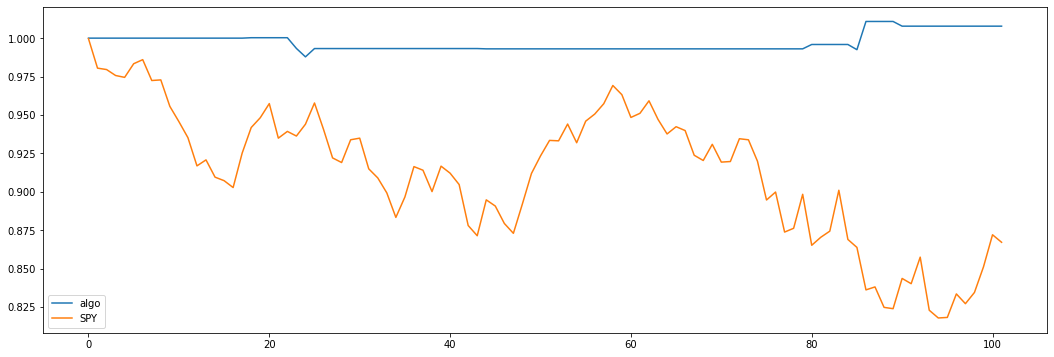

In [17]:
plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(total_ret + 1), label='algo')
plt.plot(np.nancumprod(index_ret + 1), label=index_comp)
plt.legend()

In [ ]:
def metrics_calc(cumret):
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

In [18]:
metrics = pd.DataFrame(index=['Algo', index_comp], columns=['Total return', 'APR', 'Sharpe', 'Max Drawdown', 'Max Drawdown Duration'])
metrics.loc['Algo'] = metrics_calc(np.nancumprod(total_ret + 1))
metrics.loc[index_comp] = metrics_calc(np.nancumprod(index_ret + 1))
metrics

,Total return,APR,Sharpe,Max Drawdown,Max Drawdown Duration
Algo,0.007799,0.019378,0.577382,-0.012455,63.0
SPY,-0.132629,-0.296394,-1.330918,-0.170587,95.0
